In [1]:
# import tools #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
plt.style.use("seaborn-white")

# add code path to environment #
import sys
sys.path.insert(1, "../Code/")

# import package for sum of exponential fitting #
import config
from sumexp import *

# functions #
def fit_sumexp(data, lower, upper, resolution, geom=True):
    # fit a sum of exponentials, return model, psi values
    if geom:
        config.FIXED_RATES = np.geomspace(lower, upper, resolution)
    else:
        config.FIXED_RATES = np.linspace(lower, upper, resolution)
    startest = [1/len(config.FIXED_RATES)] * (len(config.FIXED_RATES)-1)
    model = minimize_model(startest, data)
    psi = model.x
    psi = np.append(psi, 1-sum(psi))
    return (model, psi, config.FIXED_RATES)

def single_exp(r, x):
    # get likelihood of single exponential
    return np.sum(np.log(r*np.exp(-r*x)))

def aic_eq(ll, params):
    # Calculates AIC of given likelihood and parameter numbers.
    k = len(params)
    return -2 * ll + 2 * k

def inverse_cdf(data):
    # Produce the inverse CDF of 1-d data provided.
    sorted_data = -np.sort(-data)
    prob = np.arange(0, len(data), 1) / len(data)
    return pd.DataFrame({"SortedData":sorted_data, "Probability":prob})

def sumexp_cdfeq_single(psi, lamb, x):
    # Equation for exponential distribution [CCDF]
    eq = 1 - (psi * np.exp(-lamb * x))
    return 1-eq

def sumexp_cdf_all(psi, lamb, x):
    # combined sumexp - rates fixed in global variable
    eq_vector = np.zeros((len(lamb), len(x)))
    for i in range(len(psi)):
        eq_vector[i] = sumexp_cdfeq_single(psi[i], lamb[i], x)
    eq_vector[-1] = sumexp_single(1-sum(psi), lamb[-1], x)
    return sum(eq_vector)


def predict(data, prest, fun):
    # Get predicted data from optimised model parameter values
    ivdata = inverse_cdf(data)
    lengths = np.linspace(max(data),
                          min(data),
                          num = len(data))
    prediction = fun(*prest, lengths)
    #prediction = inverse_cdf(prediction)
    df = pd.DataFrame({"SortedData"  : ivdata["SortedData"],
                       "Probability" : ivdata["Probability"],
                       "Lengths"     : lengths,
                       "Prediction"  : prediction})
    return df

def predict_fig(data, prest, fun):
    # Create plot with model fit line
    df = predict(data, prest, fun)
    plt.figure()
    plt.figure(figsize=cm2inch(15, 20))
    l1 = plt.plot(df["SortedData"],
                  df["Probability"],
                  label = "Distance",
                  linewidth=3)
    l2 = plt.plot(df["Lengths"],
                  df["Prediction"],
                  linewidth=3)
    plt.xlabel("Foraging Distance (Km)", fontsize='large')
    plt.ylabel("Probability", fontsize='large')
    return plt

def cm2inch(*tupl):
    # Convert cm to Inch for plotting
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def exp_eq(lamb, x):
    # Equation for exponential distribution [CCDF]
    eq = 1-np.exp(-lamb * x)
    return 1-eq

In [52]:
## Load in and prepare data for fitting ##
path = "../Data/Distances.csv"
data = pd.read_csv(path)

# remove values bellow 1km and normalise detection difference
# remove data bellow 1km and remove detection difference [For trucated plots/fits]
#data = data[data["Distance_Km"] > 1.0]
#data["Distance_Km"] = data["Distance_Km"] - 1

# subset the data by locations
rural_dist = data["Distance_Km"][data["Location"] == "ROT"]
urban_dist = data["Distance_Km"][data["Location"] == "ZSL"]
all_dist = data["Distance_Km"]

# extract month from data
data["Date"] = pd.to_datetime(data["Date"])
data["Month"] = data["Date"].dt.month

# show single exp mle rate for each location and month
df = data.groupby(["Location", "Month"])['Distance_Km'].apply(lambda x: 1/np.mean(x))
#df.plot.bar()
#plt.show()

# get all data for month 4 (for all data this is the best)
m4 = data["Distance_Km"][data["Month"] == 4]

Bounds: 0.0 - 2
Resolution: 150
---
Optimization terminated successfully.
MLE: -52.62293986882982

#####



/home/joe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


Text(0.04, 0.68, 'B')

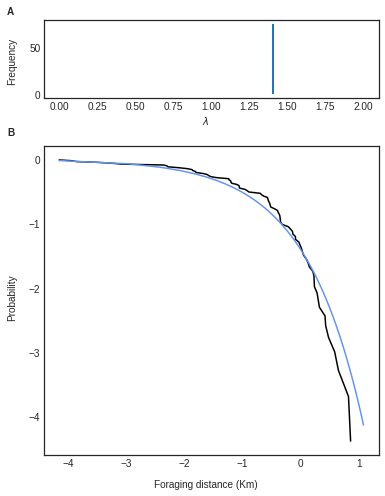

In [58]:
# Make plots # CHANGE SAVE NAME WHEN CHANGING DATA SOURCE!
import matplotlib
matplotlib.rcParams.update({'font.size': 10})


# Define the rates to use
lower = 0.
upper = 2
resolution = 150

# fit model
model, psi, rts = fit_sumexp(m4, lower, upper, resolution, geom=False)


# get the activated rates
active_p = np.where(psi > 0.001)
active_rts = rts[active_p]
active_psi = psi[active_p]

print("Bounds: {} - {}\nResolution: {}\n---\n{}\nMLE: {}".format(lower,
                                                                 upper,
                                                                 resolution,
                                                                 model.message,
                                                                 -model.fun,))

print("\n#####\n")

fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, gridspec_kw={'height_ratios': [2, 8],
                                                                      'hspace' : 0.25},
                      figsize=(6, 8))

# top - scale spectrum
values, bins, _ = ax[0].hist(rts,
                             bins=resolution,
                             weights=psi,
                             density=True)

# Bottom - cdf plot
df2 = predict(m4, [psi, rts], sumexp_cdf_all)
l1 = ax[1].plot(np.log(df2["SortedData"]),
              np.log(df2["Probability"]),
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[1].plot(np.log(df2["Lengths"]),
              np.log(df2["Prediction"]),
              linewidth=1.5,
              color="cornflowerblue")

# add text
fig.text(0.5, 0.07, 'Foraging distance (Km)', ha='center')
fig.text(0.5, 0.7, '$\lambda$', ha='center')
fig.text(0.04, 0.4, 'Probability', va='center', rotation='vertical')
fig.text(0.04, 0.81, 'Frequency', va='center', rotation='vertical')
fig.text(0.04, 0.89, 'A', fontweight='bold')
fig.text(0.04, 0.68, 'B', fontweight='bold')